In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Ejercicio 1: Análisis de Datos de Calidad del Aire en California

Utilizando el dataset de calidad del aire de California disponible en:
https://www.kaggle.com/datasets/sogun3/uspollution

O directamente del EPA (Environmental Protection Agency):
https://aqs.epa.gov/aqsweb/airdata/download_files.html

Realiza las siguientes tareas:

1. Carga el dataset en un DataFrame y filtra los datos para quedarte solo con las mediciones de California

2. Realiza una limpieza inicial de los datos:
   - Identifica y maneja valores nulos
   - Convierte las columnas de fecha al formato correcto
   - Verifica y corrige valores atípicos

3. Analiza los contaminantes principales (NO2, SO2, CO, O3):
   - Calcula promedios mensuales por ciudad
   - Identifica las 5 ciudades con mayores niveles de cada contaminante
   - Determina si hay patrones estacionales

4. Crea nuevas columnas derivadas:
   - Índice de calidad del aire simplificado
   - Clasificación por niveles de riesgo
   - Indicadores de cumplimiento de estándares EPA

5. Realiza análisis temporal:
   - Calcula tendencias anuales
   - Identifica días críticos (con valores extremos)
   - Genera medias móviles semanales y mensuales

6. Exporta los resultados:
   - Guarda un resumen por ciudad en CSV
   - Crea un archivo con los días críticos identificados
   - Genera un reporte con las estadísticas principales

Conceptos evaluados:
- Filtrado y selección de datos
- Manejo de fechas y series temporales
- Agregaciones y groupby
- Creación de nuevas variables
- Detección de outliers
- Exportación de resultados
- Análisis estadístico básico

Bonus:
- Crear visualizaciones de las tendencias encontradas
- Realizar un análisis de correlación entre contaminantes
- Implementar un sistema de alertas basado en umbrales"

In [4]:
usPollution = pd.read_csv("c:/Users/alvar/Documents/DataSets/pollution_us_2000_2016.csv")
usPollution.head(3)

,Unnamed: 0,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,...,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN
1,1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0
2,2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975,6.6,23,NaN,Parts per million,1.145833,4.2,21,NaN


In [8]:
# quitar los nulos haciendo la media
usPollution.loc[:, 'CO AQI'] = usPollution['CO AQI'].fillna(usPollution['CO AQI'].mean())
usPollution.loc[:, 'SO2 AQI'] = usPollution['SO2 AQI'].fillna(usPollution['SO2 AQI'].mean())

# Comprobacion de nulos
nulos=usPollution.isnull()
total=nulos.sum()
total_nulos = total.sum()
print("Cantidad total de nulos:", total_nulos)


Cantidad total de nulos: 0


In [ ]:
# Cambiar las fechas formato español
usPollution["Date Local"] = pd.to_datetime(usPollution["Date Local"])           # se pasa a datetime
usPollution["Date Local"] = usPollution["Date Local"].dt.strftime("%d-%m-%Y")   # se formatea
print(usPollution["Date Local"])


0          01-01-2000
1          01-01-2000
2          01-01-2000
3          01-01-2000
4          02-01-2000
              ...    
1746656    30-03-2016
1746657    31-03-2016
1746658    31-03-2016
1746659    31-03-2016
1746660    31-03-2016
Name: Date Local, Length: 1746661, dtype: object


In [13]:
# Encontrar las columnas con valores atipicos
for columna in usPollution.select_dtypes(include='number').columns:
    Q1 = usPollution[columna].quantile(0.25)
    Q3 = usPollution[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Verificar si hay valores atípicos
    outliers = usPollution[(usPollution[columna] < limite_inferior) | (usPollution[columna] > limite_superior)]
    if not outliers.empty:
        print(f"Columna '{columna}' tiene valores atípicos.")


Columna 'Site Num' tiene valores atípicos.
Columna 'NO2 Mean' tiene valores atípicos.
Columna 'NO2 1st Max Value' tiene valores atípicos.
Columna 'O3 Mean' tiene valores atípicos.
Columna 'O3 AQI' tiene valores atípicos.
Columna 'SO2 Mean' tiene valores atípicos.
Columna 'SO2 1st Max Value' tiene valores atípicos.
Columna 'CO Mean' tiene valores atípicos.
Columna 'CO 1st Max Value' tiene valores atípicos.
Columna 'CO AQI' tiene valores atípicos.


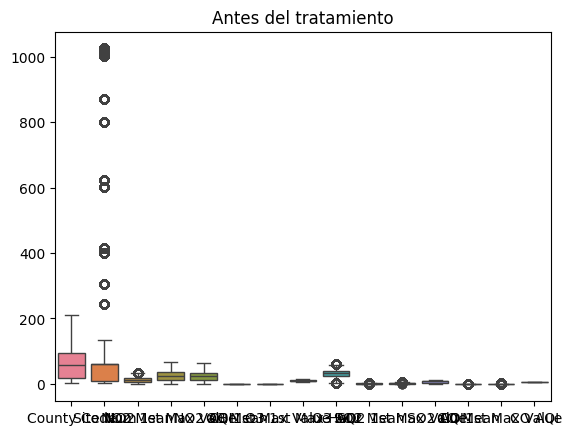

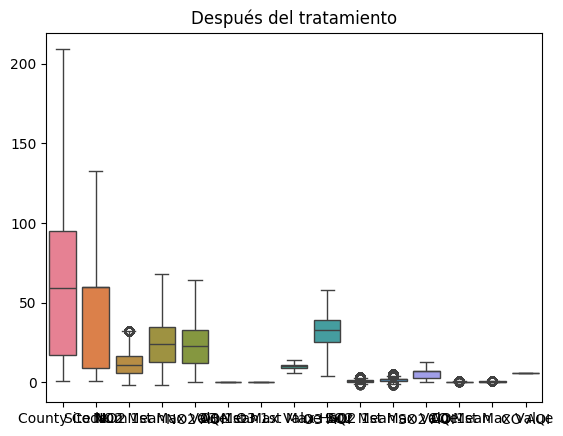

In [17]:
# ahora que sabemos cuales son todos los outlayers los metemos en un array
outlayers = ['County Code','Site Num','NO2 Mean','NO2 1st Max Value','NO2 AQI','O3 Mean','O3 1st Max Value',
             'O3 1st Max Hour','O3 AQI','SO2 Mean','SO2 1st Max Value','SO2 AQI','CO Mean','CO 1st Max Value','CO AQI']

# sns.boxplot(data=usPollution[outlayers])
# plt.title("Antes del tratamiento")
# plt.show()

# reemplazar los outlayers por la media
for columna in outlayers:
    Q1 = usPollution[columna].quantile(0.25)
    Q3 = usPollution[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    media = usPollution[columna].median()

    # Reemplazar valores por la media
    usPollution.loc[usPollution[columna] < limite_inferior, columna] = media
    usPollution.loc[usPollution[columna] > limite_superior, columna] = media

# sns.boxplot(data=usPollution[outlayers])
# plt.title("Después del tratamiento")
# plt.show()



In [ ]:
# 3. Analiza los contaminantes principales (NO2, SO2, CO, O3):
#    - Calcula promedios mensuales por ciudad

#    - Identifica las 5 ciudades con mayores niveles de cada contaminante
#    - Determina si hay patrones estacionales

In [ ]:
# 4. Crea nuevas columnas derivadas:
#    - Índice de calidad del aire simplificado
#    - Clasificación por niveles de riesgo
#    - Indicadores de cumplimiento de estándares EPA

In [ ]:
# 5. Realiza análisis temporal:
#    - Calcula tendencias anuales
#    - Identifica días críticos (con valores extremos)
#    - Genera medias móviles semanales y mensuales

In [ ]:
# 6. Exporta los resultados:
#    - Guarda un resumen por ciudad en CSV
#    - Crea un archivo con los días críticos identificados
#    - Genera un reporte con las estadísticas principales

## Ejercicio 2: Análisis de Datos del Mundial de Fútbol

Utilizando el dataset histórico de la FIFA World Cup disponible en:
https://www.kaggle.com/datasets/abecklas/fifa-world-cup

Desarrolla:
1. Carga y combina los datasets de partidos y equipos usando merge
2. Calcula estadísticas por país:
   - Total de participaciones en mundiales
   - Goles anotados y recibidos
   - Victorias, derrotas y empates
3. Identifica los 5 países más exitosos basándote en una métrica que combines
4. Crea un DataFrame pivotado que muestre el progreso de cada país por año
5. Genera visualizaciones para mostrar las tendencias históricas

Conceptos evaluados: merge de DataFrames, pivot tables, agregaciones múltiples, creación de métricas compuestas

## Ejercicio 3: Análisis de Series Temporales de Bolsa

Usando el dataset de Yahoo Finance para el índice S&P 500 (^GSPC) disponible vía pandas_datareader:
https://finance.yahoo.com/quote/%5EGSPC/

Realiza:
1. Obtén los datos de los últimos 5 años usando pandas_datareader
2. Calcula retornos diarios, semanales y mensuales
3. Identifica los 10 días con mayor volatilidad
4. Implementa una ventana móvil de 20 días para calcular:
   - Media móvil
   - Desviación estándar móvil
   - Máximos y mínimos móviles
5. Crea indicadores técnicos básicos (RSI, MACD)
6. Genera visualizaciones de los indicadores

Conceptos evaluados: series temporales, ventanas móviles, cálculos financieros, resampleo de datos

## Ejercicio 4: Análisis de Datos de COVID-19

Utilizando el dataset de Our World in Data sobre COVID-19:
https://github.com/owid/covid-19-data/tree/master/public/data

Desarrolla:
1. Carga y limpia el dataset
2. Calcula para cada país:
   - Tasa de positividad diaria
   - Media móvil de 7 días de casos nuevos
   - Tiempo hasta alcanzar picos de casos
3. Agrupa países por continente y compara métricas clave
4. Identifica correlaciones entre variables (casos, muertes, vacunación)
5. Crea un dashboard básico con las métricas más relevantes

Conceptos evaluados: limpieza de datos, análisis por grupos, correlaciones, visualización avanzada

## Ejercicio 5: Análisis de Reseñas de Amazon

Usando el dataset de reseñas de Amazon disponible en:
https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

Realiza:
1. Carga y preprocesa el dataset
2. Analiza la distribución de puntuaciones
3. Identifica patrones temporales en las reseñas:
   - Evolución de puntuaciones promedio por mes/año
   - Cambios en la longitud de las reseñas
4. Agrupa productos por categoría y analiza diferencias en:
   - Puntuación promedio
   - Cantidad de reseñas
   - Sentimiento general
5. Crea un sistema simple de detección de reseñas potencialmente falsas basado en múltiples criterios

Conceptos evaluados: text processing, análisis temporal, detección de anomalías, agregaciones complejas